In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
customers = pd.read_csv(r"C:\Users\DELL\Downloads\archive\olist_customers_dataset.csv")
orders = pd.read_csv(
    r"C:\Users\DELL\Downloads\archive\olist_orders_dataset.csv",
    parse_dates=[
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date",
    ],
)
order_items = pd.read_csv(r"C:\Users\DELL\Downloads\archive\olist_order_items_dataset.csv")
products = pd.read_csv(r"C:\Users\DELL\Downloads\archive\olist_products_dataset.csv")
payments = pd.read_csv(r"C:\Users\DELL\Downloads\archive\olist_order_payments_dataset.csv")
reviews = pd.read_csv(r"C:\Users\DELL\Downloads\archive\olist_order_reviews_dataset.csv")
sellers = pd.read_csv(r"C:\Users\DELL\Downloads\archive\olist_sellers_dataset.csv")
geolocation = pd.read_csv(r"C:\Users\DELL\Downloads\archive\olist_geolocation_dataset.csv")
cat_translation = pd.read_csv(r"C:\Users\DELL\Downloads\archive\product_category_name_translation.csv")

print("Files loaded:",
      "orders:", orders.shape,
      "order_items:", order_items.shape,
      "products:", products.shape,
      "customers:", customers.shape)

Files loaded: orders: (99441, 8) order_items: (112650, 7) products: (32951, 9) customers: (99441, 5)


# BASIC CLEANING / PREP

In [3]:
order_items["price"] = pd.to_numeric(order_items["price"], errors="coerce").fillna(0.0)

# map category to english
cat_map = dict(zip(cat_translation["product_category_name"],
                   cat_translation["product_category_name_english"]))
products["category_english"] = products["product_category_name"].map(cat_map)

# merge order_items with products + orders
order_items = order_items.merge(products[["product_id", "category_english"]],
                                on="product_id", how="left")
order_items = order_items.merge(orders[["order_id", "customer_id", "order_purchase_timestamp"]],
                                on="order_id", how="left")
order_items["revenue"] = order_items["price"]

# BASIC KPIs

In [4]:
total_revenue = order_items["revenue"].sum()
total_orders = orders["order_id"].nunique()
total_customers = orders["customer_id"].nunique()
aov = total_revenue / total_orders

print("\n=== KPI METRICS ===")
print(f"Total Revenue: {total_revenue:,.2f}")
print(f"Total Orders: {total_orders}")
print(f"Total Customers: {total_customers}")
print(f"Average Order Value: {aov:,.2f}")


=== KPI METRICS ===
Total Revenue: 13,591,643.70
Total Orders: 99441
Total Customers: 99441
Average Order Value: 136.68


# 4. MONTHLY REVENUE TREND


Monthly trend (first 5 rows):
     month    revenue  orders
0  2016-09     267.36       3
1  2016-10   49507.66     308
2  2016-12      10.90       1
3  2017-01  120312.87     789
4  2017-02  247303.02    1733


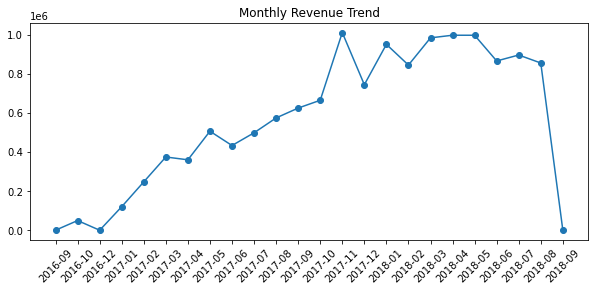

In [5]:
order_items["month"] = order_items["order_purchase_timestamp"].dt.to_period("M").astype(str)
monthly = order_items.groupby("month", as_index=False).agg(
    revenue=("revenue", "sum"),
    orders=("order_id", "nunique")
)

print("\nMonthly trend (first 5 rows):")
print(monthly.head())

plt.figure(figsize=(10,4))
plt.plot(monthly["month"], monthly["revenue"], marker="o")
plt.title("Monthly Revenue Trend")
plt.xticks(rotation=45)
plt.show()

# TOP CATEGORIES


Top 5 Categories by Revenue:
         category_english     revenue
43          health_beauty  1258681.34
70          watches_gifts  1205005.68
7          bed_bath_table  1036988.68
65         sports_leisure   988048.97
15  computers_accessories   911954.32


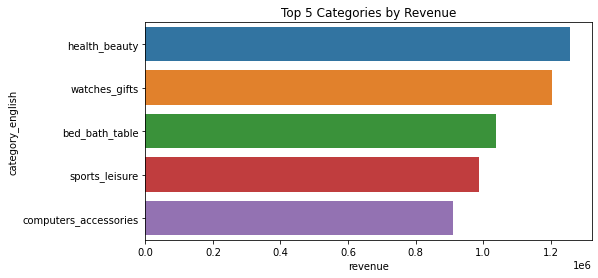

In [6]:
cat_rev = order_items.groupby("category_english", as_index=False).agg(
    revenue=("revenue","sum")
).sort_values("revenue", ascending=False)

print("\nTop 5 Categories by Revenue:")
print(cat_rev.head())

plt.figure(figsize=(8,4))
sns.barplot(data=cat_rev.head(5), x="revenue", y="category_english")
plt.title("Top 5 Categories by Revenue")
plt.show()

# PAYMENT METHODS


Payment Method Distribution:
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64


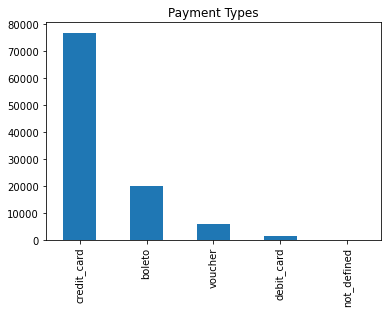

In [7]:
pay_dist = payments["payment_type"].value_counts()
print("\nPayment Method Distribution:")
print(pay_dist)

plt.figure(figsize=(6,4))
pay_dist.plot(kind="bar")
plt.title("Payment Types")
plt.show()

# REVIEWS


Average Review Score: 4.08642062404257


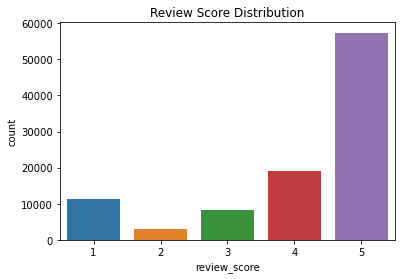

In [8]:
print("\nAverage Review Score:", reviews["review_score"].mean())

plt.figure(figsize=(6,4))
sns.countplot(x=reviews["review_score"])
plt.title("Review Score Distribution")
plt.show()

# DELIVERY PERFORMANCE


Delivery time (days):
count    96476.000000
mean        12.094086
std          9.551746
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: delivery_days, dtype: float64


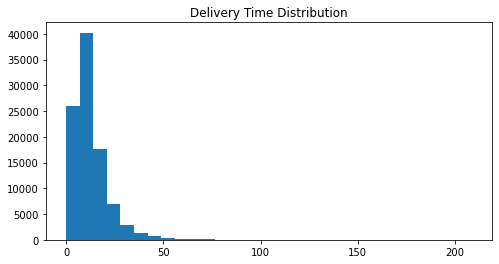

In [9]:
orders["delivery_days"] = (
    orders["order_delivered_customer_date"] - orders["order_purchase_timestamp"]
).dt.days

print("\nDelivery time (days):")
print(orders["delivery_days"].describe())

plt.figure(figsize=(8,4))
plt.hist(orders["delivery_days"].dropna(), bins=30)
plt.title("Delivery Time Distribution")
plt.show()

# SIMPLE RFM ANALYSIS

In [11]:
# snapshot date = last purchase + 1 day
snapshot_date = orders["order_purchase_timestamp"].max() + pd.Timedelta(days=1)

# aggregate per customer
rfm = order_items.groupby("customer_id").agg({
    "order_purchase_timestamp": lambda x: (snapshot_date - x.max()).days,  # Recency
    "order_id": "nunique",                                                # Frequency
    "revenue": "sum"                                                      # Monetary
}).reset_index()

rfm.columns = ["customer_id", "recency", "frequency", "monetary"]

print("\n=== RFM Sample ===")
print(rfm.head())


=== RFM Sample ===
                        customer_id  recency  frequency  monetary
0  00012a2ce6f8dcda20d059ce98491703      338          1     89.80
1  000161a058600d5901f007fab4c27140      459          1     54.90
2  0001fd6190edaaf884bcaf3d49edf079      597          1    179.99
3  0002414f95344307404f0ace7a26f1d5      428          1    149.90
4  000379cdec625522490c315e70c7a9fb      199          1     93.00


# RFM VISUALIZATION

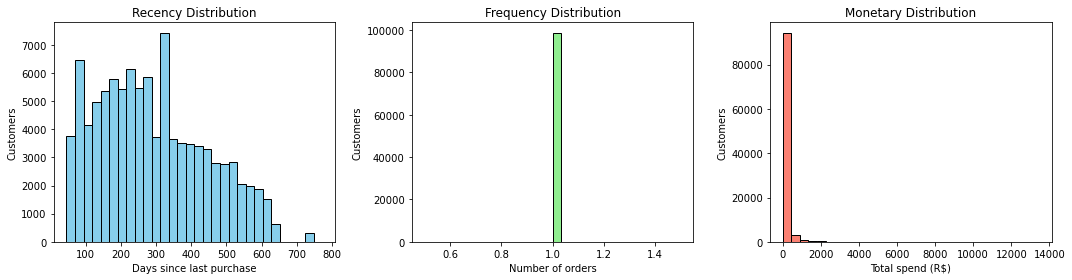

In [12]:
# -----------------------
# 10. RFM VISUALIZATION
# -----------------------

fig, axes = plt.subplots(1, 3, figsize=(15,4))

# Recency
axes[0].hist(rfm["recency"], bins=30, color="skyblue", edgecolor="black")
axes[0].set_title("Recency Distribution")
axes[0].set_xlabel("Days since last purchase")
axes[0].set_ylabel("Customers")

# Frequency
axes[1].hist(rfm["frequency"], bins=30, color="lightgreen", edgecolor="black")
axes[1].set_title("Frequency Distribution")
axes[1].set_xlabel("Number of orders")
axes[1].set_ylabel("Customers")

# Monetary
axes[2].hist(rfm["monetary"], bins=30, color="salmon", edgecolor="black")
axes[2].set_title("Monetary Distribution")
axes[2].set_xlabel("Total spend (R$)")
axes[2].set_ylabel("Customers")

plt.tight_layout()
plt.show()
